# Parte 4

O objetivo dessa parte seria focado na reducao de parametros para a criacao de um modelo adequado, identificando
quais metricas mais se correlacionam ao numero de quadros na saida.

1. Construct a training set and a test set from the trace as above.

2. Method 1: Build all subsets of the feature set X that contain either one or two features (i.e., device statistics). Compute the models for each of these sets for linear regression over the training set. Plot a histogram of the error values (NMAE) of all the models for the test set. Identify the feature set that produces the model with the smallest error and give the device statistic(s) in this set.

3. Method 2: Linear univariate feature selection. Take each feature of $X$ and compute the sample correlation of the feature with the corresponding $Y$ value over the training set. For observations $x_i, y_i$, the sample correlation is computed as $\frac{1}{m}\sum_{i=1}^m\frac{(x_i - \bar{x})(y_i - \bar{y}}{(\sigma_X * \sigma_Y)}$ whereby $\bar{x}$ and $\bar{y}$ are sample means and $m$ is the size of the training set; $\sigma_X$ is the standard deviation $\sqrt{(\frac{1}{m}\sum_{i=1}^m(x_i - \bar{x})^2)}$ and likewise for $\sigma_Y$. The correlation values fall into the interval [−1, +1]. Rank the features according to the square of the correlation values; the top feature has the highest value. Build nine feature sets composed of the top $k$ features, $k = 1..9$. Compute the model for each of these nine sets for linear regression over the training set and compute the error (NMAE) of these models over the test set. Produce a plot that shows the error value in function of the set $k$.

4. Describe your observations and conclusions.

In [1]:
from itertools import chain, combinations
import pandas as pd
import matplotlib.pyplot as pp

class Subset:
    def __init__(self, x_df, y_df, size, columns):
        self.columns = columns
        self.data = x_df[columns]
        x_train, x_test, y_train, y_test = \
            self.data[:size], self.data[size:], y_df[:size], y_df[size:]
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
    def data_width(self):
        return len(self.columns)

def superset(values):
    return map(lambda t: list(t), chain.from_iterable(combinations(values, r) for r in range(len(values) + 1)))
    
def create_subsets(x, y):
    subset_columns = list(filter(lambda t: len(t) > 0, superset(x.columns)))
    return [Subset(x, y, 2520, columns) for columns in list(subset_columns)]


x_data = pd.read_csv('./data/X.csv')
y_output = pd.read_csv('./data/Y.csv')

subsets = create_subsets(x_data, y_output)
print(f"Criado {len(subsets)} sub-sets de dados")

Criado 1023 sub-sets de dados


O modelo com as features ['sum_intr.s', 'tcpsck'] possui NMAE: 0.07798705254028886


<AxesSubplot:ylabel='Frequency'>

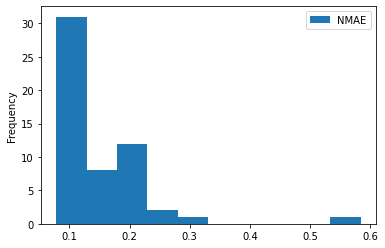

In [2]:
from sklearn import linear_model

def absolute_errors(expected, found):
    return [abs(y1 - y2) for (y1, y2) in zip(expected, found)]

def mean_errors(expected, found):
    return sum(absolute_errors(expected, found)) / len(expected)

def normalized_mean_absolute_error(expected, found):
    return mean_errors(expected, found) / expected.mean()

class TrainedModel:
    def __init__(self, data):
        self.data = data
        self.model = linear_model.LinearRegression()
        self.predicted = []
        
    def train(self):
        self.model.fit(self.data.x_train, self.data.y_train['DispFrames'])
        
    def predict(self):
        self.predicted = self.model.predict(self.data.x_test)
        
    def calculate_nmae(self):
        return normalized_mean_absolute_error(self.data.y_test['DispFrames'], self.predicted)
    
filtered_subsets = list(filter(lambda subset: subset.data_width() <= 2, subsets))

def create_and_train_model(data):
    model = TrainedModel(data)
    model.train()
    model.predict()
    return model, model.calculate_nmae()

models = [create_and_train_model(subset) for subset in filtered_subsets]

minimum_model = min(models, key = lambda t: t[1])

print(f"O modelo com as features {minimum_model[0].data.columns} possui NMAE: {minimum_model[1]}")

gathered_data = [[nmae] for (_, nmae) in models]
pd.DataFrame(gathered_data, columns=['NMAE']).plot(kind='hist', legend=True)